# Importing packages

In [94]:
%tensorflow_version 1.x 
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LSTM, SimpleRNN, TimeDistributed
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix

# Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##### Loading dataset

Dataset: IMDB (highly-polar movie reviews with 50k reviews)

CVS file dataset format: 50000 records and two column:
- review: text
- sentiment: "positive" or "negative"

In [3]:
dataset = pd.read_csv('/content/drive/My Drive/data/Text/IMDB_dataset.csv')

# Data preprocessing


- convert to lower case
- remove punctuation
- encode the label 'positive' -> 0 and 'negative' -> 1

In [4]:
dataset['review'] = dataset['review'].apply(lambda x: x.lower())
dataset['review'] = dataset['review'].apply((lambda x: re.sub('[^a-z0-9\s]','',x)))
dataset['sentiment'] = dataset['sentiment'].apply((lambda x: 1 if x == 'negative' else 0))

##### Visualizing data

In [5]:
print('Number of positive reviews: ', len(dataset[dataset['sentiment'] == 0]))
print(dataset[dataset['sentiment'] == 0].head(10))
print('Number of negative reviews: ', len(dataset[dataset['sentiment'] == 1]))
print(dataset[dataset['sentiment'] == 1].head(10))
print('Number of reviews:          ', len(dataset))

Number of positive reviews:  25000
                                               review  sentiment
0   one of the other reviewers has mentioned that ...          0
1   a wonderful little production br br the filmin...          0
2   i thought this was a wonderful way to spend ti...          0
4   petter matteis love in the time of money is a ...          0
5   probably my alltime favorite movie a story of ...          0
6   i sure would like to see a resurrection of a u...          0
9   if you like original gut wrenching laughter yo...          0
14  this a fantastic movie of three prisoners who ...          0
16  some films just simply should not be remade th...          0
18  i remember this filmit was the first film i ha...          0
Number of negative reviews:  25000
                                               review  sentiment
3   basically theres a family where a little boy j...          1
7   this show was an amazing fresh  innovative ide...          1
8   encouraged by th

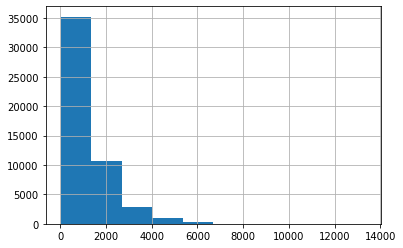

count    50000.000000
mean      1256.655080
std        950.635141
min         30.000000
25%        672.000000
50%        931.000000
75%       1526.000000
max      13346.000000
dtype: float64

In [7]:
reviews_len = [len(x) for x in dataset['review']]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

Tokenizer mapping word to int
- creat an index mapping dictionary that frequently occuring words are assigned lower indexes.
- encode the words, replace words by integer so the Network can deal with it as input

In [8]:
WORD_SIZE = 2000
tokenizer = Tokenizer(num_words = WORD_SIZE, split = ' ')
tokenizer.fit_on_texts(dataset['review'].values)
dataset['review'] = tokenizer.texts_to_sequences(dataset['review'].values)

In [9]:
print(dataset['review'].head(10))
print(dataset['sentiment'].head(10))

0    [28, 4, 1, 77, 1940, 44, 1062, 11, 100, 145, 4...
1    [3, 384, 115, 358, 12, 12, 1, 1364, 6, 52, 52,...
2    [9, 195, 10, 13, 3, 384, 98, 5, 1109, 59, 20, ...
3    [663, 211, 3, 235, 112, 3, 115, 438, 1201, 211...
4    [110, 7, 1, 59, 4, 291, 6, 3, 1377, 19, 5, 103...
5    [234, 53, 499, 17, 3, 66, 4, 2, 5, 3, 1045, 18...
6    [9, 243, 57, 38, 5, 64, 3, 4, 3, 56, 1996, 212...
7    [10, 118, 13, 33, 487, 1425, 313, 7, 1, 990, 5...
8    [32, 1, 1131, 765, 42, 10, 19, 20, 135, 9, 13,...
9    [43, 22, 38, 208, 22, 76, 38, 10, 17, 43, 22, ...
Name: review, dtype: object
0    0
1    0
2    0
3    1
4    0
5    0
6    0
7    1
8    1
9    0
Name: sentiment, dtype: int64


##### Training, Validation, Test Dataset Split

In [10]:
def split_data(train_data, train_rate, val_rate):
    X = pad_sequences(train_data['review']) # Truncating the remaining data (same length bya adding head 0)
    Y = np.array(pd.get_dummies(train_data['sentiment']).values) #one-hot-key
    data_size = len(X)
    # train set
    X_train = X[:int(train_rate * data_size)]
    Y_train = Y[:int(train_rate * data_size)]
    # validation set
    X_val = X[int(train_rate * data_size): int((train_rate + val_rate) * data_size)]
    Y_val = Y[int(train_rate * data_size): int((train_rate + val_rate) * data_size)]
    # test set
    X_test = X[int((train_rate + val_rate) * data_size):]
    Y_test = Y[int((train_rate + val_rate) * data_size):]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(dataset, 0.6, 0.2)

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(30000, 1862)
(30000, 2)
(10000, 1862)
(10000, 2)
(10000, 1862)
(10000, 2)


# Build the model

In [85]:
model = Sequential([
    Embedding(WORD_SIZE + 1, 128, input_length = X_train.shape[1]),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(2, activation = tf.nn.softmax)              
])

In [86]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [79]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1862, 128)         256128    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1862, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 387,970
Trainable params: 387,970
Non-trainable params: 0
_________________________________________________________________


In [87]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 10, validation_data = (X_val, y_val))

Train on 30000 samples, validate on 10000 samples
Epoch 1/10
30000/30000 [==============================] - 837s 28ms/sample - loss: 0.5310 - acc: 0.7343 - val_loss: 0.3860 - val_acc: 0.8336
Epoch 2/10
30000/30000 [==============================] - 839s 28ms/sample - loss: 0.3313 - acc: 0.8629 - val_loss: 0.3090 - val_acc: 0.8713
Epoch 3/10
30000/30000 [==============================] - 841s 28ms/sample - loss: 0.2829 - acc: 0.8853 - val_loss: 0.2966 - val_acc: 0.8801
Epoch 4/10
30000/30000 [==============================] - 841s 28ms/sample - loss: 0.2575 - acc: 0.8966 - val_loss: 0.3044 - val_acc: 0.8735
Epoch 5/10
30000/30000 [==============================] - 841s 28ms/sample - loss: 0.2413 - acc: 0.9045 - val_loss: 0.3079 - val_acc: 0.8717
Epoch 6/10
30000/30000 [==============================] - 843s 28ms/sample - loss: 0.2365 - acc: 0.9062 - val_loss: 0.3161 - val_acc: 0.8711
Epoch 7/10
30000/30000 [==============================] - 842s 28ms/sample - loss: 0.2335 - acc: 0.9087 

In [91]:
model.save("/content/drive/My Drive/data/model_training_data/final_model.h5")
print("Saved model to disk")

Saved model to disk


10 10


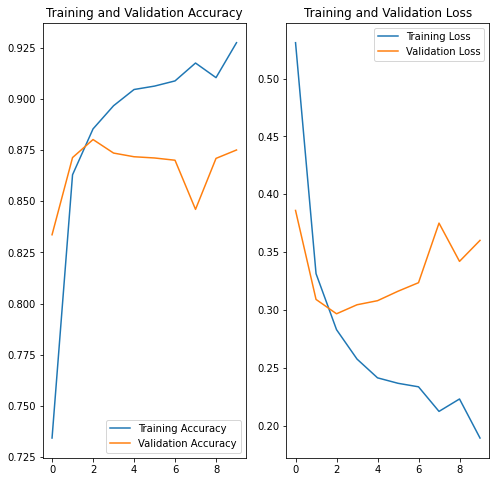

In [89]:

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)
print(len(acc), len(epochs_range))
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Testing model

Testing on test dataset

In [90]:
test_loss, test_acc = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 236s 24ms/sample - loss: 0.3630 - acc: 0.8729


In [92]:
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis = 1)

In [100]:
print(confusion_matrix(np.argmax(y_test, axis = 1), predictions))

[[4397  610]
 [ 661 4332]]


In [81]:
model = load_model("/content/drive/My Drive/data/model_training_data/model.h5")

In [22]:
review_data = pd.read_csv('/content/drive/My Drive/data/Text/IMDB_dataset.csv')

In [25]:
print(review_data[40000:40010])

                                                  review sentiment
40000  First off I want to say that I lean liberal on...  negative
40001  I was excited to see a sitcom that would hopef...  negative
40002  When you look at the cover and read stuff abou...  negative
40003  Like many others, I counted on the appearance ...  negative
40004  This movie was on t.v the other day, and I did...  negative
40005  Hickory Dickory Dock was a good Poirot mystery...  positive
40006  "One Crazy Summer" is the funniest, craziest (...  positive
40007  Low-budget schlockmeister Herschell Gordon Lew...  negative
40008  this was absolutely the most tragic pile of ci...  negative
40009  I have never understood the appeal of this sho...  negative


In [93]:
print(predictions[:10])

[1 1 1 1 1 0 0 1 1 1]


Testing on some text

In [101]:
def SentimentAnalysis(text):
    print(text)
    text = text.lower()
    text = re.sub('[^a-z0-9\s]', '', text)
    text = np.array([text])
    
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text, X_train.shape[1])
    
    predictions = model.predict(text)
    sentiment = np.argmax(predictions, axis = 1)
    if (sentiment == 0):
        print('Sentiment: Positive')
    else:
        print('Sentiment: Negative')
    print('Rating: ', np.max(predictions, axis = 1)[0])

In [104]:
SentimentAnalysis("I’m tried asking myself, “when are things going back to normal”. This song makes me hopeful that someday it will and it will be better.")

I’m tried asking myself, “when are things going back to normal”. This song makes me hopeful that someday it will and it will be better.
Sentiment: Positive
Rating:  0.78102046
